In [1]:
# Download toothbrush dataset
%%capture
!wget https://www.mydrive.ch/shares/38536/3830184030e49fe74747669442f0f282/download/420938134-1629953256/toothbrush.tar.xz
!tar -xf toothbrush.tar.xz

## Torchvision

* [Torchvision Transform](https://pytorch.org/vision/stable/transforms.html)
* [Transform documentation](https://pytorch.org/vision/0.9/transforms.html)


In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import cv2
import numpy as np

# Load an image (replace 'path/to/your/image.jpg' with your actual image path)
img = cv2.imread('/content/toothbrush/test/defective/000.png', cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(size=(224, 224)),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.ToTensor()
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Apply the augmentation to the image
augmented_img = transform(img)
augmented_img = (augmented_img.permute(1,2,0).numpy()*255).astype(np.uint8)

#display(Image.fromarray(img))
display(Image.fromarray(augmented_img))

# Print the shape of the original and augmented image
print("Original image shape:", img.shape)
print("Augmented image shape:", augmented_img.shape)


## Dataloader Example

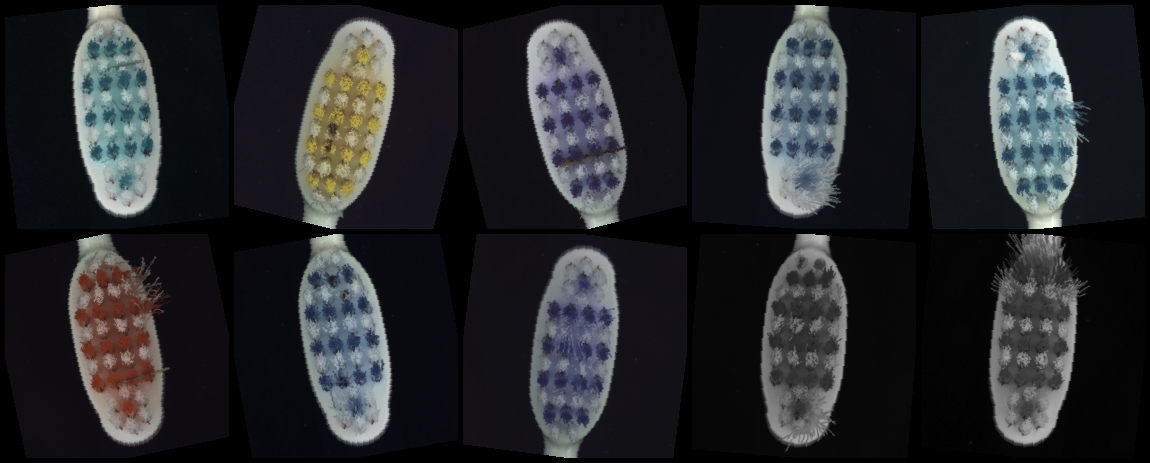

In [42]:
import os
from torch.utils.data import DataLoader,Dataset
import torchvision

folder_path = "/content/toothbrush/test/defective"

tf = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(p=0.5),
        #transforms.RandomResizedCrop(size=(224, 224)),
        #transforms.RandomCrop(size=(224, 224)),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

class ImageDataset(Dataset):
    def __init__(self, folder_path,transform=None):
        names = os.listdir(folder_path)
        self.filepaths = []
        for name in names:
            filepath = os.path.join(folder_path, name)
            self.filepaths.append(filepath)
        self.transform = transform

    def __getitem__(self, index):
        filepath = self.filepaths[index]
        x = Image.open(filepath).convert("RGB")
        if self.transform:
            x =self.transform(x)
        return x
    def __len__(self):
        return len(self.filepaths)

ds = ImageDataset(folder_path, tf)

dl = torch.utils.data.DataLoader(ds,batch_size=10,shuffle=True)
for x in dl:
    batch_grid =torchvision.utils.make_grid(x, nrow=5, padding=5)
    im = transforms.ToPILImage()(batch_grid)
    display(im)
    break

## Albumentation

In [45]:
# https://drive.google.com/drive/u/1/folders/1tEypEI3lZjff0Z8GOyeANJ3qBg46Vhzi

In [ ]:
!unzip halcon_mvtect_wood_segmentation_yolov8_seg.zip -d halcon_mvtect_wood_segmentation_yolov8_seg

In [83]:
folder_images_path = "halcon_mvtect_wood_segmentation_yolov8_seg/train/images"
folder_label_path = "halcon_mvtect_wood_segmentation_yolov8_seg/train/labels"

In [75]:
def load_yolov8_seg_labels(file_path):
    """
    Load yolov8 polylines
    """
    labels = []
    boxes = []
    with open(file_path, 'r') as file:
        for line in file:
            # Each line is expected to be 'class_id x_center y_center width height'
            #class_id, x_center, y_center, width, height = map(float, line.split())
            #boxes.append([x_center, y_center, width, height])
            l = list(map(float, line.split()))
            class_id = l[0]
            poly = l[1:]
            boxes.append(poly)
            labels.append(int(class_id))
    return boxes, labels

def convert_yolo_poly_to_absolute(normalized_coords, image_width, image_height):
    """
    Convert normalized YOLO coordinates to absolute pixel coordinates.

    Args:
    - normalized_coords (tuple): A tuple of (x_center, y_center, width, height) in normalized format.
    - image_width (int): The width of the image.
    - image_height (int): The height of the image.

    Returns:
    - tuple: A tuple of (x_min, y_min, x_max, y_max) in absolute pixel coordinates.
    """
    n = len(normalized_coords)//2
    cnt = np.array(normalized_coords).reshape(n,-1)
    cnt[:,0] = cnt[:,0]*image_width
    cnt[:,1] = cnt[:,1]*image_height
    cnt = cnt.astype(int)
    return cnt

def augment_seg(img, keypoints_yolo, class_labels, transform):

    img_height = img.shape[0]
    img_width = img.shape[1]

    # Boxes yolo to absoltute coordinate:
    keypoints_alb = []
    class_labes_alb = []
    k=0
    for keypoint_raw ,label in zip(keypoints_yolo, class_labels):
        cnt = convert_yolo_poly_to_absolute(keypoint_raw, img_width, img_height)
        cnt[:,0] = np.clip(cnt[:,0], 0, img_width-1)
        cnt[:,1] = np.clip(cnt[:,1], 0, img_height-1)
        cnt = [tuple(row) for row in cnt]
        keypoints_alb.extend(cnt)
        for i in range(0, len(cnt)):
            class_labes_alb.append(f"{label}_{k}")
        k = k+1

    tr = transform(image=img, keypoints=keypoints_alb, class_labels=class_labes_alb)
    tr_img = tr['image']
    tr_bboxes_yolo = tr['keypoints']
    tr_class_labels = tr['class_labels']

    tr_img_debug = tr_img.copy()

    # Ricostruzione:
    aug_keypoints = []
    aug_class_labels = []
    unique_elements = list(set(tr_class_labels))
    tmp_label = np.array(tr_class_labels)
    tmp_cnt = np.array(tr_bboxes_yolo)
    for label in unique_elements:
        idx = np.where(tmp_label == label)[0]
        cnt = tmp_cnt[idx].astype(float)

        cnt_norm = cnt
        cnt_norm[:,0] = cnt_norm[:,0]/img_width
        cnt_norm[:,1] = cnt_norm[:,1]/img_height
        cnt_norm = cnt_norm.reshape(-1)

        label = label.split("_")[0]

        cnt = tmp_cnt[idx].astype(int)
        cv2.drawContours(tr_img_debug, [cnt], -1, (255, 0, 0), 1)
        M = cv2.moments(cnt)
        if  M["m00"]!=0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.putText(tr_img_debug, f"{label} ", (cx, cy -10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

        aug_keypoints.append(cnt_norm)
        aug_class_labels.append(label)

    return tr_img, aug_keypoints, aug_class_labels, tr_img_debug

def get_draw_image_without_augmentation(img, keypoints_yolo, class_labels):
    img_height = img.shape[0]
    img_width = img.shape[1]
    aug_img = img
    aug_keypoints = keypoints_yolo
    aug_class_labels = class_labels
    aug_img_debug = aug_img.copy()
    for keypoint_raw ,label in zip(keypoints_yolo, class_labels):
        cnt = convert_yolo_poly_to_absolute(keypoint_raw, img_width, img_height)
        cv2.drawContours(aug_img_debug, [cnt], -1, (255, 0, 0), 1)
        M = cv2.moments(cnt)
        if M["m00"] !=0:
            cx = int(M["m10"] / M["m00"])
            cy = int(M["m01"] / M["m00"])
            cv2.putText(aug_img_debug, f"{label} ", (cx, cy -10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    return aug_img, aug_keypoints, aug_class_labels, aug_img_debug

In [82]:
import yaml
with open(f"halcon_mvtect_wood_segmentation_yolov8_seg/data.yaml", 'r') as file:
    data = yaml.safe_load(file)
    labels_name = data['names']

In [89]:
import albumentations as A
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=(-90,90), p=0.5, border_mode=cv2.BORDER_CONSTANT),
    A.ColorJitter(p=0.5,contrast=0.3, saturation=0.3, hue=0.5, brightness=(0.9,1.2)),
], keypoint_params=A.KeypointParams(format='xy', remove_invisible=True, label_fields=['class_labels']))

# Disable Transfornmation
#transform = None

In [95]:
folder_aug_images_path = "halcon_mvtect_wood_segmentation_yolov8_seg/aug/images"
folder_aug_label_path = "halcon_mvtect_wood_segmentation_yolov8_seg/aug/labels"
if not os.path.exists(folder_aug_images_path):
    os.makedirs(folder_aug_images_path)
if not os.path.exists(folder_aug_label_path):
    os.makedirs(folder_aug_label_path)

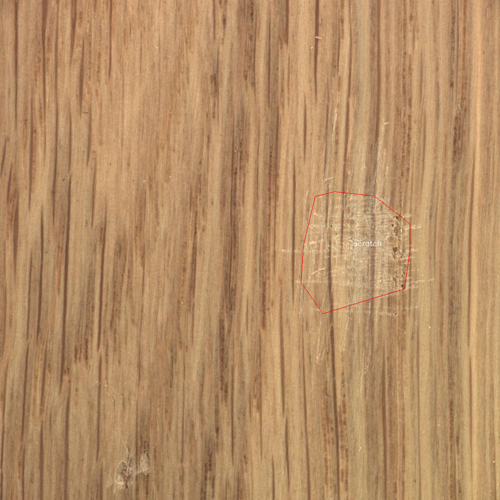

In [97]:
for name in sorted(os.listdir(folder_images_path)):
    basename = name.replace(".jpg","")
    filename = os.path.join(folder_images_path, name)
    label_path = os.path.join(folder_label_path, name.replace(".jpg",".txt"))

    keypoints_yolo, class_ids = load_yolov8_seg_labels(label_path)
    class_labels = [labels_name[class_id] for class_id in class_ids]

    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    if transform is None:
        aug_img, aug_keypoints, aug_class_labels, aug_img_debug = get_draw_image_without_augmentation(img, keypoints_yolo, class_labels)
    else:
        aug_img, aug_keypoints, aug_class_labels, aug_img_debug = augment_seg(img, keypoints_yolo, class_labels, transform)

    # save
    filepath_label_save = f"{folder_aug_label_path}/{basename}.txt"
    with open(filepath_label_save, 'w') as file:
        # Save new images and labels
        for box_yolo, class_label in zip(aug_keypoints, aug_class_labels):
            class_id = labels_name.index(class_label)
            file.write(f"{class_id} {' '.join(map(str,box_yolo))} \n")

    filepath_image_save = f"{folder_aug_images_path}/{basename}.png"
    tr_img_pil = Image.fromarray(aug_img)
    tr_img_pil.save(filepath_image_save)

    display(Image.fromarray(aug_img_debug).resize((500,500)))
    break